In [60]:
import numpy as np
import os

In [2]:
# rand_number = np.array(range(1600))

# b_genuine = np.zeros((1600,2))
# b_genuine[:,0] = range(1600)
# cnt = 0
# for u_id in range(1,41):
#   for s_id in range(1,41):
#     if s_id<21:
#       b_genuine[rand_number[cnt],1] = 1 #진서명
#     else:
#       b_genuine[rand_number[cnt],1] = 0 #위조서명
#     cnt = cnt +1

In [3]:
# #pandas 라이브러리 사용
# import pandas as pd
# #진/위조서명 여부를 csv 파일로 저장한다.
# folderpath = '/content/drive/MyDrive/Colab Notebooks'

# df_genuine = pd.DataFrame(b_genuine)
# df_genuine.columns =['ID','bGenuine'] 
# df_genuine = df_genuine.astype('int32')
# df_genuine.to_csv(f'{folderpath}/train_info.csv', index = False) 

In [61]:
filelist = os.listdir(folderpath + '/Train')
filelist2 = os.listdir(folderpath + '/Test')
n_train = len(filelist)

In [62]:
def get_max_len(folderpath_train, folderpath_test):
  n_max_len = 0
  for filename in os.listdir(folderpath_train):
    filepath = f'{folderpath_train}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  for filename in os.listdir(folderpath_test):
    filepath = f'{folderpath_test}/{filename}'
    d, tmp = load_a_sig(filepath)
    if d.shape[0] > n_max_len:
      n_max_len = d.shape[0]

  return n_max_len

In [63]:
def load_data(folderpath,n_max_len, sig_ids):
    filelist = os.listdir(folderpath)
    n_files = len(filelist)
    d=np.zeros((n_files, n_max_len, 2))

    len_sign= np.zeros(n_files)
    for i in sig_ids:
        filepath=f'{folderpath}/{i}.TXT'
        d_tmp, len_sign[i-sig_ids[0]]=load_a_sig(filepath)
       
        d[i - sig_ids[0],:d_tmp.shape[0], :] = d_tmp
    return d, len_sign


In [64]:
def load_a_sig(filepath):
    f = open(filepath, 'rt')
    nPoints = int(f.readline())

    d = np.zeros((nPoints,2))
    for i in range(nPoints):
        line = f.readline()
        toks = line.split(' ')
        d[i,:] = [int(toks[0]), int(toks[1])]
    f.close()
    return d, nPoints

In [65]:
n_max_len = get_max_len( f'{folderpath}/Train', f'{folderpath}/Test')

x_train, x_train_len = load_data(f'{folderpath}/Train', n_max_len, range(n_train))

x_test, x_test_len = load_data(f'{folderpath}/Test', n_max_len, range(n_train,1600))

In [80]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [86]:
x_train.shape

(800, 793, 2)

In [9]:
# for i in range(x_train.shape[0]):
#     len_tmp = int(x_train_len[i])
#     h_min = np.min(x_train[i, :len_tmp, 0])
#     h_max = np.max(x_train[i, :len_tmp, 0])
#     v_min = np.min(x_train[i, :len_tmp, 1])
#     v_max = np.max(x_train[i, :len_tmp, 1])

#     w_h_ratio = (v_max - v_min) / (h_max - h_min)

#     x_train[i, :len_tmp, 0] = (x_train[i, :len_tmp, 0] - h_min) / (h_max - h_min)
#     x_train[i, :len_tmp, 1] = (x_train[i, :len_tmp, 1] - v_min) / (v_max - v_min) * w_h_ratio
# for i in range(x_test.shape[0]):
#     len_tmp = int(x_test_len[i])
#     h_min = np.min(x_test[i, :len_tmp, 0])
#     h_max = np.max(x_test[i, :len_tmp, 0])
#     v_min = np.min(x_test[i, :len_tmp, 1])
#     v_max = np.max(x_test[i, :len_tmp, 1])

#     w_h_ratio = (v_max - v_min) / (h_max - h_min)

#     x_test[i, :len_tmp, 0] = (x_test[i, :len_tmp, 0] - h_min) / (h_max - h_min)
#     x_test[i, :len_tmp, 1] = (x_test[i, :len_tmp, 1] - v_min) / (v_max - v_min) * w_h_ratio

800

In [10]:
# import pandas as pd
# from tensorflow import keras

# y_pd = pd.read_csv(f'{folderpath}/train_info.csv')
# y_all = np.array(y_pd['bGenuine'])
# y_train = y_all[:n_train]
# y_train_cat = keras.utils.to_categorical(y_train)
# y_test = y_all[n_train:]

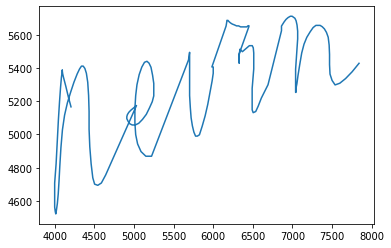

In [73]:
import matplotlib.pyplot as plt
s_id = 100
len_sig = int(x_train_len[s_id])
plt.plot(x_train[s_id,:len_sig,0],x_train[s_id,:len_sig,1])

In [82]:
# import pandas as pd
# from tensorflow import keras
# from tensorflow.keras.layers import *
# from tensorflow.keras import Sequential
# from tensorflow.keras import layers

# #모델 구조 지정
# model = Sequential()
# model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
# model.add(Conv1D(8, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2))

# model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
# model.add(Conv1D(16, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))

# model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
# model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))

# # model.add(Bidirectional(LSTM(128))) #LSTM

# model.add(Dropout(0.3))  #Dropout
# model.add(Dense(units=2, activation='softmax')) #출력층

In [34]:
model = Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D(strides=2, padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))

In [13]:
# #모델 구조 지정2
# model = Sequential()
# model.add(Conv1D(8, kernel_size=3, activation='relu'))
# model.add(Conv1D(8, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2))

# model.add(Conv1D(16, kernel_size=3, activation='relu'))
# model.add(Conv1D(16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2, input_dim=2))

# model.add(layers.Flatten())

# model.add(Dropout(0.3))  #Dropout
# model.add(Dense(units=2, activation='softmax')) #출력층

In [83]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

hist = model.fit(x=x_train, y=y_train,	epochs=70, validation_split=0.2,batch_size=16)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70


ValueError: ignored

In [20]:
#테스트
o = model.predict(x_test)

#정확도 체크
o = np.argmax(o,1)
sum(np.equal(y_test,o))/len(y_test)

0.505

In [21]:
answer = {'id': list(range(800,1600)), 'predicted': o }
submission = pd.DataFrame(data=answer)

In [69]:
submission.to_csv('submission3.csv',index=False)